In [17]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
import numpy as np
import scipy as sp
import scipy.stats
tfd = tfp.distributions

In [2]:
import matplotlib.pyplot as plt

In [18]:
normal_data = sp.stats.norm.rvs(7, 1, size=10000)

In [4]:
normal_data

array([7.7392817 , 6.94629408, 6.78185641, 5.72593642, 5.21676968,
       6.96171815, 8.57830199, 7.14369724, 8.19010729, 7.19027598])

In [19]:
def log_likelihood(scale):    
    mu = ed.Normal(tf.zeros(10000), 1, name="mu")
    y = ed.Normal(loc=mu, scale=scale ,name="y")
    return y

In [20]:
def target_log_prob_fn(mu, scale):
    log_joint = ed.make_log_joint_fn(log_likelihood)
    return log_joint(scale, mu=mu, y=normal_data)

In [21]:
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn = lambda mu: target_log_prob_fn(mu, scale),
    step_size=0.01, num_leapfrog_steps=5)

In [325]:
hmc_kernel._parameters

{'target_log_prob_fn': <function __main__.<lambda>(mu)>,
 'step_size': 0.01,
 'num_leapfrog_steps': 5,
 'state_gradients_are_stopped': False,
 'seed': None,
 'name': 'hmc_kernel',
 'step_size_update_fn': None}

In [22]:
scale = 1
# states, kernel_results = tfp.mcmc.sample_chain(
#         num_results=1,
#         current_state=tf.random_uniform([]),
#         kernel = hmc_kernel, num_burnin_steps=1)
with tf.Session() as sess:
    #states, kernel_results = sess.run([states, kernel_results])      
    #print(states)
    for i in range(10): 
        states, kernel_results = tfp.mcmc.sample_chain(
            num_results=1,
            previous_kernel_results=kernel_results,
            current_state=tf.zeros(10000),
            kernel = hmc_kernel, num_burnin_steps=1)
        states, kernel_results = sess.run([states, kernel_results])        
        print(states)
        scale = 1
        hmc_kernel._parameters['target_log_prob_fn'] = lambda mu: target_log_prob_fn(mu, scale)

ValueError: Input tensor 'mcmc_sample_chain_16/scan/while/smart_for_loop/while/Identity_3:0' enters the loop with shape (1,), but has shape () after one iteration. To allow the shape to vary across iterations, use the `shape_invariants` argument of tf.while_loop to specify a less-specific shape.

In [303]:
with tf.Session() as sess:    
    states, kernel_results = tfp.mcmc.sample_chain(
        num_results=10,
        previous_kernel_results=lerne-
        current_state=tf.ones(10),
        kernel = hmc_kernel, num_burnin_steps=1)
    states, is_accepted_ = sess.run([states, kernel_results.is_accepted])        
    print(states)                

[[1.0844768  1.0082383  1.0460254  1.0939064  1.0531303  1.0448735
  0.94925696 1.0640278  0.9304308  1.0152818 ]
 [1.0629882  1.0266073  1.0794894  1.0831101  1.0046453  1.0346719
  0.9595953  1.1672632  0.9441022  1.0180659 ]
 [1.0655863  0.95028114 1.1260467  1.1147741  1.0834298  1.1035016
  0.93631923 1.0690825  0.9848436  1.0145452 ]
 [1.1023191  0.9698799  1.2619845  1.0224382  1.008305   1.1477499
  0.96289307 1.179276   0.92264813 1.0043108 ]
 [1.057156   0.93501407 1.3132374  1.0973014  1.0421745  1.1838218
  0.91519356 1.2013195  0.9558141  1.0139446 ]
 [1.0427247  0.95843065 1.2866824  1.170803   1.0808272  1.2629215
  0.9155602  1.1425757  1.0173576  0.9886214 ]
 [1.0628582  0.9918261  1.3174332  1.0990072  1.0739585  1.2203102
  0.9192689  1.1556888  0.93430144 1.0464644 ]
 [1.0316112  1.0055637  1.3195558  1.1445163  1.1083722  1.1648514
  0.8436839  1.2170347  0.8444571  1.0548108 ]
 [1.1140171  1.0517284  1.4000834  1.0931014  1.0572765  1.1787436
  0.89177585 1.227096

In [74]:
with tf.Session() as sess:
    sam = sess.run([normal])

In [114]:
scipy.stats.uniform.rvs(0, 1)

0.27924741993949376

In [143]:
def sample_poisson(last, accept=0.5):
    proposal = scipy.stats.poisson.rvs(last)
    q_p = scipy.stats.poisson.pmf(proposal, last)
    q_last = scipy.stats.poisson.pmf(last, proposal)
    f_p = scipy.stats.poisson.pmf(proposal, 7)
    f_last = scipy.stats.poisson.pmf(last, 7)
    
    a = np.minimum(1., (f_p * q_last) / (f_last * q_p))
    if a > scipy.stats.uniform.rvs(0, 1):
        return proposal
    return last

In [160]:
proposals = np.ones(10000)
for i in range(1, 10000):
    proposals[i] = sample_poisson(proposals[i - 1])

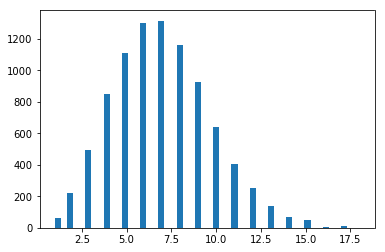

In [161]:
plt.hist(proposals[1000:], bins=50);

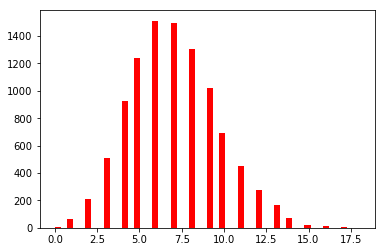

In [162]:
plt.hist(scipy.stats.poisson.rvs(7, size=10000), color="red", bins=50);

In [220]:
def log_likelihood(loc):    
    sigma = ed.InverseGamma(1, 1, name="sigma")
    y = ed.Normal(loc=loc, scale=sigma, name="y")
    return y

In [221]:
def target_log_prob_fn(sigma):
    return ed.make_log_joint_fn(log_likelihood)(
        loc=loc,
        sigma=sigma,
        y=normal_data)

In [226]:
kernel = tfp.mcmc.HamiltonianMonteCarlo(
                step_size=0.5, num_leapfrog_steps=2,
                target_log_prob_fn=target_log_prob_fn)

In [ ]:
def sample_chain(
    num_results,
    current_state,
    previous_kernel_results=None,
    kernel=None,
    num_burnin_steps=0,
    num_steps_between_results=0,
    trace_fn=lambda current_state, kernel_results: kernel_results,
    return_final_kernel_results=False,
    parallel_iterations=10,
    name=None):

 
  with tf.compat.v1.name_scope(
      name, "mcmc_sample_chain",
      [num_results, num_burnin_steps, num_steps_between_results]):
    num_results = tf.convert_to_tensor(
        value=num_results, dtype=tf.int32, name="num_results")
    num_burnin_steps = tf.convert_to_tensor(
        value=num_burnin_steps, dtype=tf.int32, name="num_burnin_steps")
    num_steps_between_results = tf.convert_to_tensor(
        value=num_steps_between_results,
        dtype=tf.int32,
        name="num_steps_between_results")
    current_state = tf.nest.map_structure(
        lambda x: tf.convert_to_tensor(value=x, name="current_state"),
        current_state)
    if previous_kernel_results is None:
      previous_kernel_results = kernel.bootstrap_results(current_state)

    if trace_fn is None:
      # It simplifies the logic to use a dummy function here.
      trace_fn = lambda *args: ()
      no_trace = True
    else:
      no_trace = False
    if trace_fn is sample_chain.__defaults__[4]:
      warnings.warn("Tracing all kernel results by default is deprecated. Set "
                    "the `trace_fn` argument to None (the future default "
                    "value) or an explicit callback that traces the values "
                    "you are interested in.")

    def _trace_scan_fn(state_and_results, num_steps):
      next_state, current_kernel_results = mcmc_util.smart_for_loop(
          loop_num_iter=num_steps,
          body_fn=kernel.one_step,
          initial_loop_vars=list(state_and_results),
          parallel_iterations=parallel_iterations)
      return next_state, current_kernel_results

    (_, final_kernel_results), (all_states, trace) = mcmc_util.trace_scan(
        loop_fn=_trace_scan_fn,
        initial_state=(current_state, previous_kernel_results),
        elems=tf.one_hot(
            indices=0,
            depth=num_results,
            on_value=1 + num_burnin_steps,
            off_value=1 + num_steps_between_results,
            dtype=tf.int32),
        # pylint: disable=g-long-lambda
        trace_fn=lambda state_and_results: (state_and_results[0],
                                            trace_fn(*state_and_results)),
        # pylint: enable=g-long-lambda
        parallel_iterations=parallel_iterations)

    if return_final_kernel_results:
      return CheckpointableStatesAndTrace(
          all_states=all_states,
          trace=trace,
          final_kernel_results=final_kernel_results)
    else:
      if no_trace:
        return all_states
      else:
    return StatesAndTrace(all_states=all_states, trace=trace)

In [234]:
loc = 2
states = tf.ones(1)
with tf.Session() as sess:    
    states, kernel_results = tfp.mcmc.sample_chain(
        current_state=None,
        num_results=1,
        kernel=kernel, num_burnin_steps=0)

    states, kernel_results = sess.run([states, kernel_results])            
    states = states.reshape((1))
    print(states)

ValueError: None values not supported.

In [196]:
kernel._parameters["target_log_prob_fn"]

<bound method Distribution.log_prob of <tfp.distributions.Normal 'Normal_120/' batch_shape=() event_shape=() dtype=float32>>

In [203]:
current_state = tf.zeros(1)
proposals = np.zeros(shape=(2, 10000))
with tf.Session() as sess:    
    for idx in range(1, 10000):
        proposals[0, i] = sample_poisson(proposals[0, i - 1])
        states, kernel_results = tfp.mcmc.sample_chain(
            current_state=states,            
            num_results=1,
            kernel=kernel, num_burnin_steps=0)
        states, kernel_results = sess.run([states, kernel_results])
        kernel._parameters["target_log_prob_fn"] = 
        states = states.reshape((1))
        if idx % 10 == 0:
            print(states)        
        proposals[1, i] = states

SyntaxError: invalid syntax (<ipython-input-203-38932f371cd0>, line 11)

In [193]:
np.ndarray.astype(proposals[0, i])

TypeError: descriptor 'astype' requires a 'numpy.ndarray' object but received a 'numpy.float64'